# Solution : Graph to Eager mode migration

## Introduction
In this workshop, we implement and train a feed-forward neural network (also known as an "MLP" for "multi-layer perceptron") on a dataset called "Fashion MNIST", consisting of small greyscale images of items of fashion.

## Learning Objectives 
* Understand how to use **Tensorflow Eager** and **Keras Layers** to build a neural network architecture
* Understand how a model is trained and evaluated

In [2]:
#@title Imports (RUN ME!) { display-mode: "form" }
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running Eagerly')

Running in Eager mode.


## The Data

In this practical, we use the Fashion MNIST dataset consisting of 70,000 greyscale images and their labels. The dataset is divided
 into 60,000 training images and 10,000 test images. The idea is to train a **classifier** to identify the class value (what type of fashion item it is) given the image. We train and *tune* a model on the 60,000 training images and then evaluate how well it classifies the 10,000 test images that the model did not see during training. This task is an example of a **supervised learning** problem, where we are given both input and labels (targets) to learn from. This is in contrast to **unsupervised learning** where we only have inputs from which to learn patterns or **reinforcement learning** where an agent learns how to maximise a reward signal through interaction with its environment. 

In [3]:
# Tensorflow has convenient modules for loading a number of standard datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Construct a validation set
Next, we remove 10,000 images and labels from the training set to use as a validation set. We will come back to the validation set later! 

In [4]:
# Construct a validation set from the last 10000 images and labels from 
# train_and_validation_images and train_and_validation_labels
validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]

### What does the data look like?
Each image in the dataset consists of a 28 x 28 matrix of greyscale pixels. The values are between 0 and 255 where 0 represents black, 255 represents white and there are many shades of grey in-between. Each image is assigned a corresponding numerical label, so the image in ```train_images[i]``` has its corresponding label stored in ```train_labels[i]```. We also have a lookup array called ```text_labels``` to associate a text description with each of the numerical labels. For example, the label 1 is associated with the text description "Trouser".

The 2 cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset. 

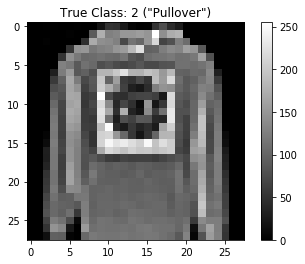

In [5]:
# We use the Matplotlib plotting library to visualise an image selected at random from the training set 
plt.figure()
random_index = np.random.randint(0, len(train_images))
plt.imshow(train_images[random_index], cmap='gray')
plt.colorbar()
numerical_label = train_labels[random_index]
text_description = text_labels[numerical_label]
plt.title('True Class: {} ("{}")'.format(numerical_label, text_description))

plt.gca().grid(False)

/home/med/anaconda3/envs/insta/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


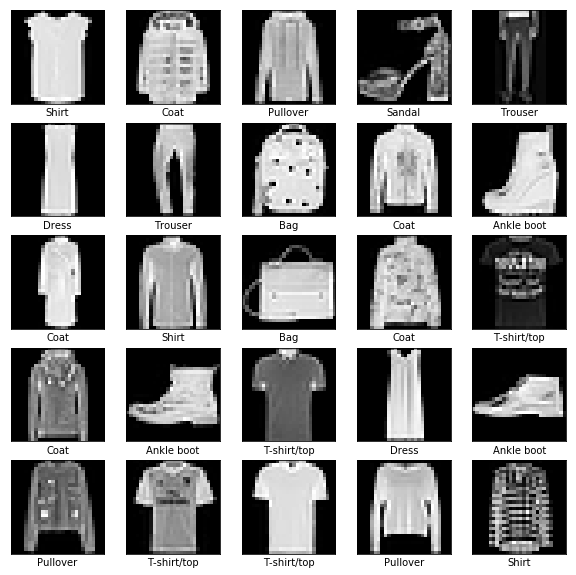

In [6]:
# Another view, showing 25 randomly selected images at a time
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap=plt.cm.gray)
    plt.xlabel(text_labels[train_labels[img_index]])

### Exploratory Task
Run the above cells multiple times to get a good sense of the dataset. Look at the general structure of the images and their corresponding labels. Can you spot some classes that might be difficult for a classifier to distinguish? If so, why do you think they would be difficult to distinguish? Chat to your neighbour about this. 


### Preparing the data with TensorFlow
At the moment, our training data consists of two large tensors. The images are stored in a tensor of shape $[50000, 28, 28]$, consisting of all the $28 \times 28$ images matrices stacked together. The labels are stored in a 1D vector of shape $[50000]$. We wish to train a model using **mini-batch stochastic gradient descent**. In order to do so, we need to shuffle the data and split it into smaller (mini-)batches. We also convert the data from numpy arrays to TensorFlow Tensors.


In order to do this batching (and shuffling) we will use the Tensorflow [Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which is a set of simple reusable components that allow you to build efficient data pipelines. Data is said to "stream" through the pipeline, meaning that when something at the output of the pipeline wants data, the pipeline will provide that data as soon as it has enough, rather than waiting to process all the data. This allows you to easily build pipelines that work on large datasets without having to load it all into memory in one go!

We build this pipeline step-by-step:

We being by defining the ```batch_size``` hyperparameter of our model. This hyperparameter controls the sizes of the mini-batches (chunks) of data that we use to train the model. The value you use will affect the memory usage, speed of convergence and potentially also the performance of the model. It also interacts with the *learning rate* used in gradient descent. 

In [7]:
batch_size = 128

The first component we add will group the image and label tensors together into a tuple and then split them into individual entries - ie. 50000 tuples containing a (28, 28) dimensional image and 1D label associated with that image. The following line adds this splitting component to the pipeline.

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

The next thing we do is apply a map operation. This lets us run an arbitrary function on each element. The function we provide returns the image values divided by 255 and converted ('cast') to a float and the label converted to a 32-bit integer.

**NOTE**: "Lambda" functions are just one-line, anonymous functions. In this case, it defines a function that takes arguments x and y (before the colon), and outputs their manipulated values (after the colon).

In [9]:
# Divide image values and cast to float so that they end up as a floating point number between 0 and 1
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))  

Then we add a **shuffle** component. This returns a random element from the pipeline. Can you spot a potential problem here? 


In [10]:
# Shuffle the examples.
train_ds = train_ds.shuffle(buffer_size=batch_size * 10) 

The final component in our pipeline is the batch component. This just requests `batch_size` elements from the previous pipeline component, groups them together into a single tensor and returns that.

In [11]:
# Now "chunk" the examples into batches
train_ds = train_ds.batch(batch_size)  

# The output of this pipeline will be tuples of tensors containing images and labels. 
# The images will be of shape (batch_size, 28, 28) and the labels of shape (batch_size, )

## Define the model

In this section we'll build a classifier. A **classifier** is a function that takes an object's characteristics (or "features") as inputs and outputs a prediction of the class (or group) that the object belongs to. It may make a single prediction for each input or it may output some score (for example a probability) for each of the possible classes. Specifically, we will build a classifier that takes in (a batch of) 28 x 28 Fashion MNIST images as we've seen above, and outputs predictions about which class the image belongs to. 

For each (batch of) input images, we will use a **feed-forward neural network** to compute un-normalised scores (also known as **logits**) for each of the 10 possible classes that the image could belong to. We can then **classify** the image as belonging to the class which receives the highest score, or we can quantify the model's "confidence" about the classifications by converting the scores into a probability distribution. 

A feed-forward neural network consisting of $N$ layers, applied to an input vector $\mathbf{x}$ can be defined as:

\begin{equation}
\mathbf{f_0} = \mathbf{x} \\
\mathbf{f_i} = \sigma_i(\mathbf{W_if_{i-1}} + \mathbf{b_i}) \ \ \ i \in [1, N]
\end{equation}

Each layer has a particular number, $m_i$, of neurons. The parameters of a layer consist of a matrix $\mathbf{W_i} \in \mathbb{R}^{m_i \times m_{i-1}}$ and bias vector $\mathbf{b_i} \in \mathbb{R}^{m_i}$. Each layer also has a non-linear activation function $\sigma_i$. 

**QUESTION**: Why do you think the activation functions need to be *non-linear*? What would happen if they were *linear*? **HINT**: If you're stuck, consider the very simplest case of an identity activation (which essentially does nothing) and ignore the biases. 


### Aside: Activation functions



Activation functions are a core ingredient in deep neural networks. In fact they are what allows us to make use of multiple layers in a neural network. There are a number of different activation functions, each of which are more or less useful under different circumstances. The four activation functions that you are most likely to encounter are, arguably, [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU), [Tanh](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh), [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid), and [Softmax](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax). 

Read more about activation functions [here](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6). 

### Configure the feed-forward neural network
We configure the feed-forward neural network part of our classifier using the [Keras Layers API](https://www.tensorflow.org/api_docs/python/tf/keras/layers). This API consists of various reusable building-blocks that allow us to define many different neural network architectures (similar to how we defined a data pipeline earlier!). 

Here we use the [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) component which allows us to wrap together a sequence of layers. An important point to note here is that we are **configuring** our neural network architecture as a pipeline. We can think of the resulting ```model`` variable as a *function* that takes a batch of images as inputs and outputs a batch of logits. 

In [12]:
model = tf.keras.Sequential([
    # Convert the 28x28 image into a flat vector of 28x28 = 784 values
    tf.keras.layers.Flatten(input_shape=(28, 28), name='flatten_input'),  
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),  
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 10 neurons
    tf.keras.layers.Dense(10, name='hidden_to_logits'),  
])

The following summary shows how many parameters each layer is made up of (the number of entries in the weight matrics and bias vectors). Note that a value of ```None``` in a particular dimension of a shape means that the shape will dynamically adapt based on the shape of the inputs. In particular, the output shape of the ```flatten_input``` layer will be $[N, 784]$ when the batch of inputs passed to the model has shape $[N, 28, 28]$

In [13]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (Flatten)      (None, 784)               0         
_________________________________________________________________
input_to_hidden1 (Dense)     (None, 256)               200960    
_________________________________________________________________
hidden1_to_hidden2 (Dense)   (None, 128)               32896     
_________________________________________________________________
hidden_to_logits (Dense)     (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


### Define the loss
As we did in the previous practical, we need to specify a loss function for our classifier. This tells us how good our model's predictions are compared to the actual labels (the targets), with a lower loss meaning better predictions. The standard loss function to use with a **multi-class classifier** is the **cross-entropy loss** also known as the "negative log likelihood". Suppose we have a classification problem with $C$ classes. A classifier is trained to predict a probability distribution $p(y | X_i)$ for each input $X_i$ from a batch of $N$ examples. The vector $p(y|X_i)$ is $C$ dimensional, sums to one, and we use $p(y|X_i)_c$ to denote the $c$th component of  $p(y|X_i)$. The true class for example $i$ in the batch is $y_i$ and we define the indicator function $\mathbb{1}[y_i=c]$ to be 1 whenever $y_i = c$ and $0$ otherwise. This classifier has a cross-entropy loss of

$- \frac{1}{N}\sum_{i=1}^N \sum_{c=1}^C log( p(y|X_i)_c) \mathbb{1}[y_i=c]$

**NOTE**: The indicator is one for the true class label, and zero everywhere else. So in that sum, the indicator just "lifts out" the $log(p(y|X_i))$ values for all true classes. So the above expression is minimised (note the negative at the front) when the model places all its probability mass on the true labels for all the examples. Remember that  log(1)=0 , thus the closer all probabilities of $y_i = c$ are to one, the lower the loss will be and the better the model will be performing.


Fortunately we don't need to write this function ourselves as Tensorflow provides a version called 

```tf.nn.sparse_softmax_cross_entropy_with_logits```. 

**NOTE**: This function actually computes the cross entropy loss directly from the un-normalised logits, rather than from the probability distribution for numerical stability.

By the way, for training data in which the labels are themselves distributions rather than exact values, this definition of cross-entropy still works, where the indicator function is replaced with the corresponding probability of each class for that example. This might be important when we are not sure whether the training data has been labelled correctly, or when the data was labelled by a human who gave their answer along with a degree of confidence that the answer was correct

## Train the model
Now that we have our data, data processing pipeline, our neural network architecture and the corresponding loss that we want to minimise, we need to **train** the model using batched stochastic gradient descent. We do this in multiple **epochs**, which is a single iteration through the entire training dataset. Briefly, in each epoch we loop over all the batches of images and labels, and for each batch we perform the following steps:
* Get the **predictions** of the model on the current batch of images
* Compute the **average loss** values across the batch, telling us how good these predictions are / how close they are to the true targets.
* Compute the **gradient of the average loss** (or the average gradient of the losses in the batch) with respect to each of the model's parameters: This tells us the direction to move in "parameter space" to decrease the loss value
* **Adjust the parameters** by taking a small step in the direction of each component of the gradient (where the learning rate controls the size of the step)

During training we also track some metrics, such as the loss and accuracy to see how well the classifier is doing. Note that the cell below may take a few minutes to run! 

### Hint: Computing gradients in Eager mode

In graph mode, TensorFlow builds up a "computation graph" which captures all operations of the model and their dependencies. For training, the gradient can then be computed by traversing backwards from every node through its dependents and applying the "chain rule" of differentiation. 

However, in Eager mode, we don't have the concept of the computation graph anymore. Operations are performed imperatively (in the order in which they were executed). TensorFlow therefore uses a mechanism called the "GradientTape" for computing gradients in Eager mode. Basically, the gradient tape records the order of all operations as they are executed, and can then be "run backwards" (traversed from last to first operation) for computing the gradients.

Epoch 000: Loss: 0.300, Accuracy: 89.002%
Epoch 001: Loss: 0.279, Accuracy: 89.776%
Epoch 002: Loss: 0.268, Accuracy: 90.106%
Epoch 003: Loss: 0.248, Accuracy: 90.704%
Epoch 004: Loss: 0.239, Accuracy: 91.184%
Epoch 005: Loss: 0.228, Accuracy: 91.468%
Epoch 006: Loss: 0.220, Accuracy: 91.770%
Epoch 007: Loss: 0.210, Accuracy: 92.000%
Epoch 008: Loss: 0.201, Accuracy: 92.548%
Epoch 009: Loss: 0.195, Accuracy: 92.728%
Epoch 010: Loss: 0.187, Accuracy: 93.018%
Epoch 011: Loss: 0.177, Accuracy: 93.324%
Epoch 012: Loss: 0.173, Accuracy: 93.454%
Epoch 013: Loss: 0.165, Accuracy: 93.828%
Epoch 014: Loss: 0.156, Accuracy: 94.166%
Epoch 015: Loss: 0.155, Accuracy: 94.062%
Epoch 016: Loss: 0.145, Accuracy: 94.574%
Epoch 017: Loss: 0.143, Accuracy: 94.570%
Epoch 018: Loss: 0.141, Accuracy: 94.774%
Epoch 019: Loss: 0.135, Accuracy: 94.894%
Epoch 020: Loss: 0.129, Accuracy: 95.130%
Epoch 021: Loss: 0.125, Accuracy: 95.232%
Epoch 022: Loss: 0.114, Accuracy: 95.772%
Epoch 023: Loss: 0.112, Accuracy: 

Text(0.5,1,'Accuracy vs epochs')

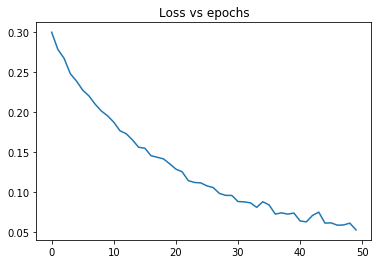

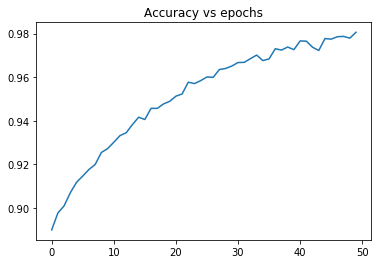

In [15]:
# Create an optimizer
# The optimizer is responsible for controlling the learning rate
optimizer = tf.train.AdamOptimizer()

step_counter = tf.train.get_or_create_global_step()  # Just a variable that keeps track of how many training steps we've run
num_epochs = 50  # The number of epochs to run

# Lists to store the loss and accuracy of every epoch
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
    # Tensorflow provides a convenient API for tracking a number of metrics during training/evaluation
    loss_avg = tfe.metrics.Mean()
    accuracy = tfe.metrics.Accuracy()

    # Loop over our data pipeline
    for step, (image_batch, label_batch) in enumerate(train_ds):

    # Initialise a GradientTape to track the operations
    with tf.GradientTape() as tape:
        # Compute the logits (un-normalised scores) of the current batch of examples 
        # using the neural network architecture we defined earlier

        logits = model(image_batch, training=True)
        
        # Compute the cross-entropy loss of the classification outputs on this batch
        loss_value = tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=label_batch)  
        
        # Compute the average loss over the batch
        loss_value =  tf.reduce_mean(loss_value)  

        # Add current batch loss to our loss metric tracker - note the function call semantics
        loss_avg(loss_value)  
        
        # Compare most likely predicted label to actual label
        accuracy(tf.argmax(logits, axis=1, output_type=tf.int32), label_batch)

    # Play the tape backwards and get the gradient of the loss of the current batch
    # Note we're now outside the scope of the with-block above
    grads = tape.gradient(loss_value, model.variables)
    # Use the optimizer to apply the gradients to the model parameters along with
    # its internal learning rate
    optimizer.apply_gradients(
        zip(grads, model.variables), global_step=step_counter)

    # Get the average loss and accuracy for the epoch
    epoch_loss = loss_avg.result()
    epoch_losses.append(epoch_loss)
    epoch_accuracy = accuracy.result()
    epoch_accuracies.append(epoch_accuracy)
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss, epoch_accuracy))

# Plot the loss for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), epoch_losses)
plt.title('Loss vs epochs')

# Plot the accuracy for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), epoch_accuracies)
plt.title('Accuracy vs epochs')

## Testing

After 50 epochs of training on our training set, we obtain a loss of around 0.061 and accuracy of 97.7%. That's pretty good, right? 


In [0]:
# We need to apply the same pre-processing to the test set as we did to the training set
# Since we don't need batching or shuffling, we can do this directly instead of 
# building a tf.Dataset pipeline

tf_test_images = tf.convert_to_tensor(test_images, dtype=tf.float32) / 255.0
tf_test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

In [17]:
test_accuracy = tfe.metrics.Accuracy()

test_logits = 

# Compute the average cross-entropy loss of the classification over the entire test set
test_loss = 
test_loss = 

# Compare predicted labels to actual labels
test_accuracy(tf.argmax(test_logits, axis=1, output_type=tf.int32), tf_test_labels)

print('Completed testing on', tf_test_images.shape[0], 'examples...')
print('Loss: {:.3f}, Accuracy: {:.3%}'.format(test_loss, test_accuracy.result()))

Completed testing on 10000 examples...
Loss: 0.607, Accuracy: 88.920%
